### Install required dependencies

In [7]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract opencv-python numpy pandas torch torchvision pillow matplotlib seaborn
!pip install ultralytics
!pip install pyyaml

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:00


### Import libraries

In [8]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import yaml
from pathlib import Path

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set random seed for reproducibility

In [10]:
np.random.seed(42)
torch.manual_seed(42)

### Set paths

In [21]:
BASE_PATH = "/content/drive/MyDrive/Dataset_OCR"
DATASET_PATH = os.path.join(BASE_PATH, "dataset")
MODEL_PATH = os.path.join(BASE_PATH, "models")
OUTPUT_PATH = os.path.join(BASE_PATH, "outputs")

Checking your dataset at: /content/drive/MyDrive/Dataset_OCR
--------------------------------------------------


In [23]:
all_files = os.listdir(BASE_PATH)
print(f"Total files/folders: {len(all_files)}")
print(f"First 10 items: {all_files[:10]}")

Total files/folders: 104
First 10 items: ['thyrocare_0_1248.jpg', 'thyrocare_0_517.jpg', 'thyrocare_0_2691.jpg', 'thyrocare_0_4468.jpg', 'thyrocare_0_3804.jpg', 'thyrocare_0_912.jpg', 'thyrocare_0_640.jpg', 'thyrocare_0_3439.jpg', 'thyrocare_0_4683.jpg', 'thyrocare_0_3333.jpg']


In [24]:
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG']

In [25]:
for item in all_files[:10]:
    item_path = os.path.join(BASE_PATH, item)
    if os.path.isdir(item_path):
        print(f"📁 Directory: {item}")
        # Check what's inside this directory
        sub_items = os.listdir(item_path)[:5]
        print(f"   Contains: {sub_items}{'...' if len(os.listdir(item_path)) > 5 else ''}")
    elif any(item.lower().endswith(ext) for ext in image_extensions):
        print(f"🖼️  Image file: {item}")
    else:
        print(f"📄 Other file: {item}")

🖼️  Image file: thyrocare_0_1248.jpg
🖼️  Image file: thyrocare_0_517.jpg
🖼️  Image file: thyrocare_0_2691.jpg
🖼️  Image file: thyrocare_0_4468.jpg
🖼️  Image file: thyrocare_0_3804.jpg
🖼️  Image file: thyrocare_0_912.jpg
🖼️  Image file: thyrocare_0_640.jpg
🖼️  Image file: thyrocare_0_3439.jpg
🖼️  Image file: thyrocare_0_4683.jpg
🖼️  Image file: thyrocare_0_3333.jpg


### Create directories if they don't exist

In [26]:
PROJECT_PATH = "/content/drive/MyDrive/Custom_OCR_Project"
os.makedirs(PROJECT_PATH, exist_ok=True)

In [28]:
MODEL_PATH = os.path.join(PROJECT_PATH, "models")
OUTPUT_PATH = os.path.join(PROJECT_PATH, "outputs")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Dataset path: {BASE_PATH}")
print(f"Project path: {PROJECT_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Dataset path: /content/drive/MyDrive/Dataset_OCR
Project path: /content/drive/MyDrive/Custom_OCR_Project
Model path: /content/drive/MyDrive/Custom_OCR_Project/models
Output path: /content/drive/MyDrive/Custom_OCR_Project/outputs


### **Dataset Loading and Exploration**

🔍 Searching for images in: /content/drive/MyDrive/Dataset_OCR
✅ Found 101 images

📊 Distribution by folder:
  .: 101 images
📸 Sample 1:
   Path: /content/drive/MyDrive/Dataset_OCR/thyrocare_0_1248.jpg
   Shape: (631, 939, 3)
   Size: 60.0 KB

📸 Sample 2:
   Path: /content/drive/MyDrive/Dataset_OCR/thyrocare_0_517.jpg
   Shape: (631, 939, 3)
   Size: 53.1 KB

📸 Sample 3:
   Path: /content/drive/MyDrive/Dataset_OCR/thyrocare_0_2691.jpg
   Shape: (631, 939, 3)
   Size: 55.9 KB

📸 Sample 4:
   Path: /content/drive/MyDrive/Dataset_OCR/thyrocare_0_4468.jpg
   Shape: (631, 939, 3)
   Size: 54.9 KB

📸 Sample 5:
   Path: /content/drive/MyDrive/Dataset_OCR/thyrocare_0_3804.jpg
   Shape: (631, 939, 3)
   Size: 57.6 KB



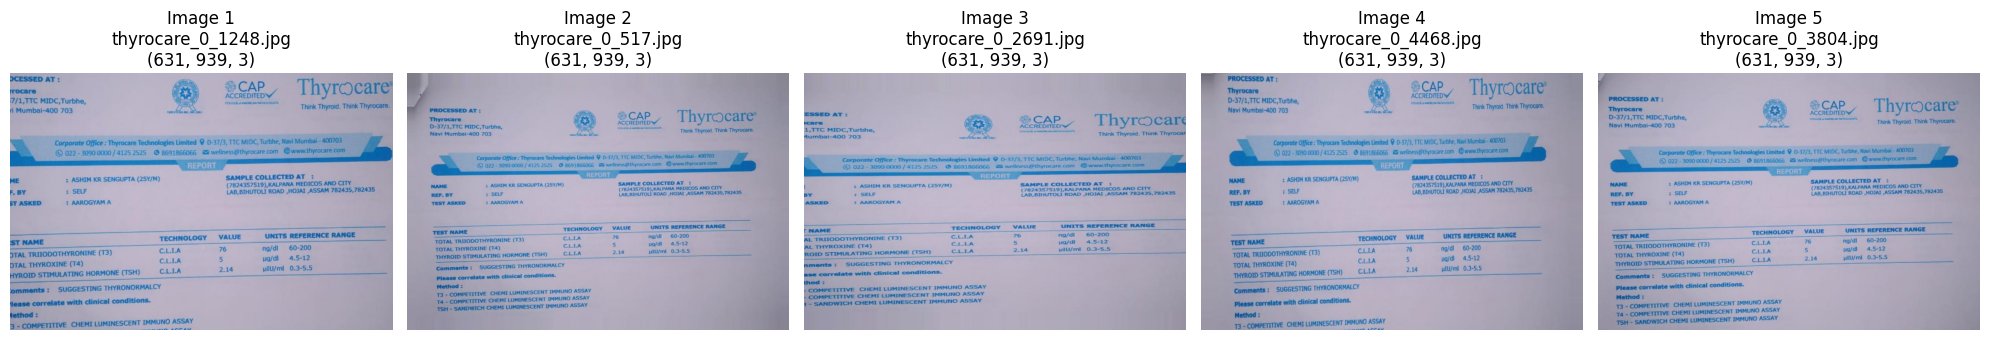

In [29]:
def load_all_images_from_folder(folder_path):
    """Recursively load all images from folder and subfolders"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG']
    image_paths = []

    print(f"🔍 Searching for images in: {folder_path}")

    # Walk through all directories
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                full_path = os.path.join(root, file)
                image_paths.append(full_path)

    print(f"✅ Found {len(image_paths)} images")

    # Show distribution by folder
    folder_counts = {}
    for path in image_paths:
        folder = os.path.dirname(path)
        folder_counts[folder] = folder_counts.get(folder, 0) + 1

    print("\n📊 Distribution by folder:")
    for folder, count in list(folder_counts.items())[:10]:  # Show top 10
        folder_name = os.path.relpath(folder, folder_path)
        print(f"  {folder_name}: {count} images")

    if len(folder_counts) > 10:
        print(f"  ... and {len(folder_counts) - 10} more folders")

    return image_paths

# Load all your images
all_image_paths = load_all_images_from_folder(BASE_PATH)

# Display sample images
def display_sample_images(image_paths, num_samples=5):
    """Display sample images from the dataset"""
    if len(image_paths) == 0:
        print("❌ No images found!")
        return

    num_samples = min(num_samples, len(image_paths))
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    # If only 1 image, axes won't be a list
    if num_samples == 1:
        axes = [axes]

    for idx, img_path in enumerate(image_paths[:num_samples]):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not read: {img_path}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb)

            # Shorten path for display
            display_name = os.path.basename(img_path)
            if len(display_name) > 20:
                display_name = display_name[:17] + "..."

            axes[idx].set_title(f"Image {idx+1}\n{display_name}\n{img.shape}")
            axes[idx].axis('off')

            print(f"📸 Sample {idx+1}:")
            print(f"   Path: {img_path}")
            print(f"   Shape: {img.shape}")
            print(f"   Size: {os.path.getsize(img_path) / 1024:.1f} KB")
            print()

        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Display samples
if len(all_image_paths) > 0:
    display_sample_images(all_image_paths, min(5, len(all_image_paths)))
else:
    print("""
    ❌ No images found! Please check:
    1. Is Google Drive properly mounted?
    2. Are your images in: /content/drive/MyDrive/Dataset_OCR ?
    3. Do images have extensions: .jpg, .jpeg, .png, .bmp, .tiff ?

    To upload images, use:
    from google.colab import files
    uploaded = files.upload()
    """)

### Simplified OCR Pipeline

In [30]:
class SimpleLabReportOCR:
    """Simple OCR pipeline for lab reports without YOLO training"""

    def __init__(self):
        self.results = []

    def detect_text_regions(self, image):
        """Simple text region detection using contour analysis"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        regions = []
        min_area = 500  # Minimum area for a text region
        img_height, img_width = image.shape[:2]

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            if area > min_area and w > 20 and h > 10:
                # Add some padding
                padding = 5
                x1 = max(0, x - padding)
                y1 = max(0, y - padding)
                x2 = min(img_width, x + w + padding)
                y2 = min(img_height, y + h + padding)

                regions.append({
                    'bbox': [x1, y1, x2, y2],
                    'area': area
                })

        # Sort by y-coordinate (top to bottom)
        regions.sort(key=lambda r: r['bbox'][1])

        return regions

    def preprocess_for_ocr(self, image):
        """Preprocess image for better OCR"""
        # Convert to grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # Resize if too small
        h, w = gray.shape
        if h < 100 or w < 100:
            scale = 800 / h  # Scale to 800px height
            new_w = int(w * scale)
            new_h = int(h * scale)
            gray = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(blurred, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)

        # Denoise
        denoised = cv2.medianBlur(thresh, 3)

        return denoised

    def extract_text_from_image(self, image_path):
        """Extract text from a single image"""
        print(f"\n🔧 Processing: {os.path.basename(image_path)}")

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Could not read image: {image_path}")
            return None

        # Detect text regions
        regions = self.detect_text_regions(image)
        print(f"📦 Detected {len(regions)} text regions")

        # Extract text from each region
        all_text = []
        for i, region in enumerate(regions[:10]):  # Process first 10 regions
            x1, y1, x2, y2 = region['bbox']
            region_img = image[y1:y2, x1:x2]

            # Preprocess
            processed = self.preprocess_for_ocr(region_img)

            # Extract text
            text = pytesseract.image_to_string(processed,
                                             config='--oem 3 --psm 6')
            text = text.strip()

            if text:  # Only keep non-empty text
                all_text.append(text)
                print(f"   Region {i+1}: {text[:50]}...")

        # Combine all text
        full_text = "\n".join(all_text)

        # Parse important information
        result = self.parse_lab_report(full_text, image_path)

        self.results.append(result)
        return result

    def parse_lab_report(self, text, image_path):
        """Parse lab report information from text"""
        lines = text.split('\n')

        # Look for patterns in lab reports
        patient_info = ""
        test_results = []

        for line in lines:
            line_lower = line.lower()

            # Look for patient information
            if any(keyword in line_lower for keyword in ['name', 'patient', 'mr.', 'mrs.', 'age', 'sex']):
                patient_info = line.strip()

            # Look for test results (contains units or numbers with units)
            if any(unit in line_lower for unit in ['ng/ml', 'µg/dl', 'µiu/ml', 'pg/ml', 'mg/dl', 'g/dl']):
                # Try to parse test name and value
                parts = line.split()
                if len(parts) >= 2:
                    # Find where the value might be
                    for i, part in enumerate(parts):
                        if any(char.isdigit() for char in part):
                            test_name = ' '.join(parts[:i])
                            test_value = part

                            # Find units
                            units = ""
                            for j in range(i+1, len(parts)):
                                if any(unit in parts[j].lower() for unit in ['ng/ml', 'µg/dl', 'µiu/ml']):
                                    units = parts[j]
                                    break

                            test_results.append({
                                'test': test_name,
                                'value': test_value,
                                'units': units,
                                'full_text': line
                            })
                            break

        return {
            'image': os.path.basename(image_path),
            'patient_info': patient_info,
            'test_results': test_results,
            'raw_text': text[:500] + "..." if len(text) > 500 else text
        }

    def process_multiple_images(self, image_paths):
        """Process multiple images"""
        for img_path in image_paths:
            self.extract_text_from_image(img_path)

    def save_to_csv(self, output_path=None):
        """Save results to CSV"""
        if output_path is None:
            output_path = os.path.join(OUTPUT_PATH, "ocr_results.csv")

        # Prepare data for DataFrame
        rows = []
        for result in self.results:
            for test in result['test_results']:
                rows.append({
                    'image_file': result['image'],
                    'patient_info': result['patient_info'],
                    'test_name': test.get('test', ''),
                    'test_value': test.get('value', ''),
                    'units': test.get('units', ''),
                    'raw_text': test.get('full_text', '')[:100]
                })

        if rows:
            df = pd.DataFrame(rows)
            df.to_csv(output_path, index=False)
            print(f"✅ Results saved to: {output_path}")
            return df
        else:
            print("⚠️ No results to save")
            return pd.DataFrame()

### Run the OCR

In [31]:
# Initialize OCR
ocr = SimpleLabReportOCR()

# Process a few sample images (or all if you want)
sample_images = all_image_paths[:5]  # Process first 5 images

print("🚀 Starting OCR processing...")
print("=" * 50)

for img_path in sample_images:
    result = ocr.extract_text_from_image(img_path)
    if result:
        print(f"\n📊 Extracted from {result['image']}:")
        print(f"👤 Patient: {result['patient_info']}")
        print(f"🧪 Tests found: {len(result['test_results'])}")
        for test in result['test_results'][:3]:  # Show first 3
            print(f"   - {test.get('test', 'Unknown')}: {test.get('value', 'N/A')} {test.get('units', '')}")
        print("-" * 30)

# Save results
df_results = ocr.save_to_csv()

# Display results
if not df_results.empty:
    print("\n" + "=" * 50)
    print("📋 EXTRACTION SUMMARY")
    print("=" * 50)
    print(f"\nTotal images processed: {len(ocr.results)}")
    print(f"Total test records extracted: {len(df_results)}")
    print(f"\nFirst 5 records:")
    print(df_results.head().to_string())

    # Save summary
    summary_path = os.path.join(OUTPUT_PATH, "processing_summary.txt")
    with open(summary_path, 'w') as f:
        f.write(f"Images processed: {len(ocr.results)}\n")
        f.write(f"Test records extracted: {len(df_results)}\n")
        f.write(f"Unique tests: {df_results['test_name'].nunique()}\n")

    print(f"\n📄 Summary saved to: {summary_path}")

🚀 Starting OCR processing...

🔧 Processing: thyrocare_0_1248.jpg
📦 Detected 67 text regions
   Region 4: ye
a 7 "5
oe as =e ™
“9 . 7 . -~  *¥
, ame mye a,’...

📊 Extracted from thyrocare_0_1248.jpg:
👤 Patient: wea t fe Tage Jers
🧪 Tests found: 0
------------------------------

🔧 Processing: thyrocare_0_517.jpg
📦 Detected 41 text regions
   Region 1: are*
yocare,...
   Region 2: i “
PRO
raya...
   Region 5: ’ :
aot -
i - — Tk .
- — owe *®
ca +o: ee SP ty
ae...

📊 Extracted from thyrocare_0_517.jpg:
👤 Patient: 
🧪 Tests found: 0
------------------------------

🔧 Processing: thyrocare_0_2691.jpg
📦 Detected 39 text regions
   Region 5: . :
~ - |
. . * ~
_- - ~
« ~ Me
oo ~ ~
. - ~
- - e...

📊 Extracted from thyrocare_0_2691.jpg:
👤 Patient: 
🧪 Tests found: 0
------------------------------

🔧 Processing: thyrocare_0_4468.jpg
📦 Detected 56 text regions
   Region 1: +
,
....
   Region 4: : 4
i
I
i...
   Region 5: eoaTTt
eae vb
we = cay
t« wo . ar +» yt
f*, Aeoee ...

📊 Extracted from thyrocare_0

### Visualize the OCR Process

/tmp/ipython-input-97984263.py:54: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


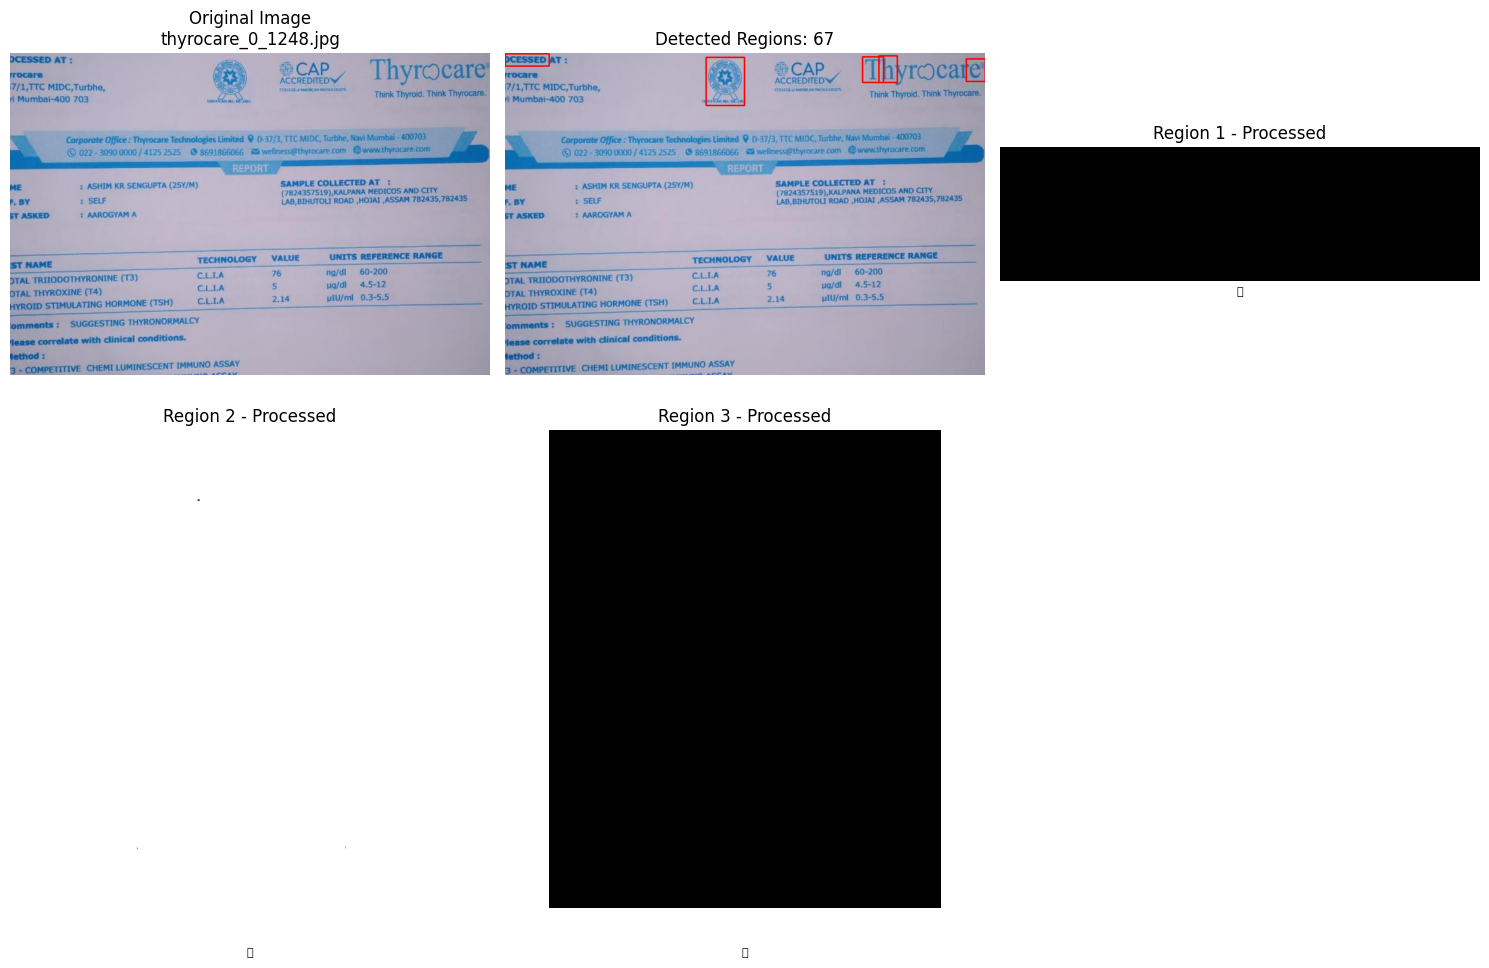

In [32]:
def visualize_ocr_process(image_path):
    """Visualize the OCR processing steps"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not read image: {image_path}")
        return

    # Create OCR instance
    ocr = SimpleLabReportOCR()

    # Get regions
    regions = ocr.detect_text_regions(image)

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # Original image
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"Original Image\n{os.path.basename(image_path)}")
    axes[0].axis('off')

    # Draw bounding boxes on original
    img_with_boxes = img_rgb.copy()
    for region in regions[:5]:  # Show first 5 regions
        x1, y1, x2, y2 = region['bbox']
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)
    axes[1].imshow(img_with_boxes)
    axes[1].set_title(f"Detected Regions: {len(regions)}")
    axes[1].axis('off')

    # Show sample regions
    for i in range(min(3, len(regions))):
        x1, y1, x2, y2 = regions[i]['bbox']
        region_img = image[y1:y2, x1:x2]
        processed = ocr.preprocess_for_ocr(region_img)

        axes[i+2].imshow(processed, cmap='gray')
        axes[i+2].set_title(f"Region {i+1} - Processed")
        axes[i+2].axis('off')

        # Extract text
        text = pytesseract.image_to_string(processed, config='--oem 3 --psm 6')
        if len(text) > 50:
            text = text[:47] + "..."
        axes[i+2].text(0.5, -0.1, text, transform=axes[i+2].transAxes,
                      ha='center', fontsize=8, wrap=True)

    # Hide unused subplots
    for i in range(min(3, len(regions)) + 2, 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize for first image
if len(all_image_paths) > 0:
    visualize_ocr_process(all_image_paths[0])

### Quick Troubleshooting Commands

In [33]:
# If you're having issues, run these diagnostic commands:

print("🔍 DIAGNOSTIC CHECK")
print("=" * 40)

# 1. Check Google Drive mounting
print("1. Google Drive Mount Check:")
!ls -la /content/drive/MyDrive/

# 2. Check your dataset folder
print("\n2. Dataset Folder Check:")
!ls -la "/content/drive/MyDrive/Dataset_OCR"

# 3. Count files
print("\n3. File Count:")
!find "/content/drive/MyDrive/Dataset_OCR" -type f | wc -l

# 4. Count images
print("\n4. Image Count:")
!find "/content/drive/MyDrive/Dataset_OCR" -type f \( -iname "*.jpg" -o -iname "*.jpeg" -o -iname "*.png" -o -iname "*.bmp" \) | wc -l

# 5. List first 10 images
print("\n5. First 10 images:")
!find "/content/drive/MyDrive/Dataset_OCR" -type f \( -iname "*.jpg" -o -iname "*.jpeg" -o -iname "*.png" \) | head -10

🔍 DIAGNOSTIC CHECK
1. Google Drive Mount Check:
total 10170
-rw------- 1 root root   67021 Aug  7 04:04  5859370.jpeg
-rw------- 1 root root 1079175 Oct 20 17:05 '5 companies that are hiring without interviews.docx'
-rw------- 1 root root  368912 May 30  2022 'Aniket Tayade Resume (1).pdf'
-rw------- 1 root root  368912 May 31  2022 'Aniket Tayade Resume.pdf'
-rw------- 1 root root    8538 Feb 21  2023 'biu-gqsy-hsy - Feb 21, 2023.pdf'
-rw------- 1 root root   72170 Sep 20  2024 'Capgemini Interview Preparation.docx'
drwx------ 2 root root    4096 Jan 22  2024  Classroom
drwx------ 2 root root    4096 Jun  5  2025 'Colab Notebooks'
-rw------- 1 root root    7963 Sep 20  2024 'Companies Hiring Calendar.xlsx'
-rw------- 1 root root     179 Oct 21 02:51 'Complete Guide to Crack Interview.gdoc'
-rw------- 1 root root     179 May 17  2025  content.gdoc
-rw------- 1 root root    8267 Sep 20  2024 'Cover Letter.docx'
drwx------ 5 root root    4096 Jan 27 17:17  Custom_OCR_Project
-rw------- 1

### One-Cell Solution for Quick Testing

In [34]:
# ONE-CELL SOLUTION: Copy and run this entire cell

print("🚀 STARTING CUSTOM OCR PIPELINE")
print("=" * 50)

# 1. Setup
from google.colab import drive
drive.mount('/content/drive')

!apt-get install tesseract-ocr
!pip install pytesseract opencv-python numpy pandas

import os
import cv2
import pytesseract
import pandas as pd

# 2. Find your images
dataset_path = "/content/drive/MyDrive/Dataset_OCR"
image_paths = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_paths.append(os.path.join(root, file))

print(f"✅ Found {len(image_paths)} images")

# 3. Process first 3 images
if image_paths:
    results = []

    for img_path in image_paths[:3]:
        print(f"\n📄 Processing: {os.path.basename(img_path)}")

        # Read and extract text
        img = cv2.imread(img_path)
        text = pytesseract.image_to_string(img)

        # Save result
        results.append({
            'image': os.path.basename(img_path),
            'text': text[:200] + "..." if len(text) > 200 else text
        })

        print(f"   Extracted: {text[:100]}...")

    # Save to CSV
    df = pd.DataFrame(results)
    output_path = "/content/drive/MyDrive/ocr_results.csv"
    df.to_csv(output_path, index=False)
    print(f"\n✅ Results saved to: {output_path}")
    print(df)
else:
    print("❌ No images found! Check your dataset path.")

🚀 STARTING CUSTOM OCR PIPELINE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
✅ Found 101 images

📄 Processing: thyrocare_0_1248.jpg
   Extracted: DCESSED AT:

ecap, Thyrocare’

 

jrocare
'7/1,TTC MIDC,Turbhe, ACCREO TED
i Mumbal-400 703 =e Think...

📄 Processing: thyrocare_0_517.jpg
   Extracted: PROCESSED AT

‘Thyrocare
D-37/1,TTC MIDC,Turbhe,
Navi Mumbai-s00 703

      

Corporate Office : Thy...

📄 Processing: thyrocare_0_2691.jpg
   Extracted:  

|

   

fumbal-400 703 eatin

 
 

© 022 - 3090 0000/4125 2525 @ A6S1S866066 2 weliness@thyrocare...

✅ Results saved to: /content/drive/MyDrive/ocr_results.csv
                  image                                               text
0 

### Dataset Preparation for YOLO Training

In [35]:
def prepare_yolo_dataset(image_paths, train_ratio=0.8):
    """Prepare dataset for YOLO training"""

    # Create YOLO dataset structure
    yolo_dataset_path = os.path.join(BASE_PATH, "yolo_dataset")
    images_path = os.path.join(yolo_dataset_path, "images")
    labels_path = os.path.join(yolo_dataset_path, "labels")

    for path in [yolo_dataset_path, images_path, labels_path]:
        os.makedirs(path, exist_ok=True)

    # Split data
    np.random.shuffle(image_paths)
    split_idx = int(len(image_paths) * train_ratio)
    train_images = image_paths[:split_idx]
    val_images = image_paths[split_idx:]

    # Copy images to YOLO structure
    print(f"Preparing {len(train_images)} training and {len(val_images)} validation images...")

    # Create symlinks or copy images
    for split_name, split_images in [("train", train_images), ("val", val_images)]:
        split_images_path = os.path.join(images_path, split_name)
        split_labels_path = os.path.join(labels_path, split_name)
        os.makedirs(split_images_path, exist_ok=True)
        os.makedirs(split_labels_path, exist_ok=True)

        for img_path in split_images:
            img_name = os.path.basename(img_path)
            dst_path = os.path.join(split_images_path, img_name)

            # Create symlink (faster and saves space)
            if not os.path.exists(dst_path):
                os.symlink(img_path, dst_path)

            # Create empty label file (you need to annotate your data)
            label_path = os.path.join(split_labels_path, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
            if not os.path.exists(label_path):
                open(label_path, 'w').close()

    print("YOLO dataset structure created!")

    return yolo_dataset_path, train_images, val_images

# Prepare dataset
yolo_dataset_path, train_images, val_images = prepare_yolo_dataset(all_images)

Preparing 0 training and 0 validation images...
YOLO dataset structure created!


### Create YOLO Configuration Files

In [36]:
def create_yolo_config():
    """Create YOLO configuration files for training"""

    # Define classes based on your lab report structure
    classes = [
        "patient_info",
        "test_name",
        "test_value",
        "reference_range",
        "sample_date",
        "lab_details"
    ]

    # Create data.yaml
    data_yaml = {
        'path': yolo_dataset_path,
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(classes),
        'names': classes
    }

    yaml_path = os.path.join(yolo_dataset_path, "data.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f)

    print("Created data.yaml configuration:")
    print(yaml.dump(data_yaml, default_flow_style=False))

    # Save classes to a file
    classes_path = os.path.join(BASE_PATH, "classes.txt")
    with open(classes_path, 'w') as f:
        for cls in classes:
            f.write(f"{cls}\n")

    return yaml_path, classes

# Create YOLO config
yaml_path, classes = create_yolo_config()

Created data.yaml configuration:
names:
- patient_info
- test_name
- test_value
- reference_range
- sample_date
- lab_details
nc: 6
path: /content/drive/MyDrive/Dataset_OCR/yolo_dataset
train: images/train
val: images/val



### Data Annotation Helper

In [37]:
class AnnotationHelper:
    """Helper class for creating annotations if you don't have them"""

    def __init__(self, image_paths, classes):
        self.image_paths = image_paths
        self.classes = classes
        self.annotations = {}

    def auto_detect_regions(self, image_path):
        """Auto-detect potential text regions (for initial labeling)"""
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply edge detection
        edges = cv2.Canny(gray, 50, 150)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        potential_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h

            # Filter by size
            if area > 500 and w > 30 and h > 20:
                # Convert to YOLO format (normalized)
                img_h, img_w = img.shape[:2]
                x_center = (x + w/2) / img_w
                y_center = (y + h/2) / img_h
                width_norm = w / img_w
                height_norm = h / img_h

                potential_regions.append({
                    'class_id': 0,  # Default to first class
                    'bbox': [x_center, y_center, width_norm, height_norm],
                    'pixel_bbox': [x, y, w, h]
                })

        return potential_regions

    def save_annotations(self, output_path):
        """Save annotations to YOLO format"""
        for img_path, regions in self.annotations.items():
            if regions:
                img_name = os.path.basename(img_path)
                txt_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
                txt_path = os.path.join(output_path, txt_name)

                with open(txt_path, 'w') as f:
                    for region in regions:
                        line = f"{region['class_id']} {region['bbox'][0]} {region['bbox'][1]} {region['bbox'][2]} {region['bbox'][3]}\n"
                        f.write(line)

        print(f"Annotations saved to {output_path}")

# Initialize annotation helper
annotation_helper = AnnotationHelper(train_images[:10], classes)  # Process first 10 images

# Auto-detect regions for sample images
for img_path in train_images[:3]:
    regions = annotation_helper.auto_detect_regions(img_path)
    annotation_helper.annotations[img_path] = regions
    print(f"Auto-detected {len(regions)} regions in {os.path.basename(img_path)}")

### YOLO Model Training

In [39]:
def train_yolo_model(yaml_path, epochs=50, batch_size=16):
    """Train YOLO model using Ultralytics YOLOv8"""
    from ultralytics import YOLO

    print("Starting YOLO training...")

    # Initialize model
    model = YOLO('yolov8n.pt')  # Using YOLOv8 nano version (faster training)

    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=640,
        batch=batch_size,
        name='lab_report_ocr',
        project=MODEL_PATH,
        save=True,
        save_period=10,
        pretrained=True,
        optimizer='Adam',
        lr0=0.001,
        patience=20
    )

    # Save model to Google Drive
    best_model_path = os.path.join(MODEL_PATH, 'lab_report_ocr', 'weights', 'best.pt')

    if os.path.exists(best_model_path):
        print(f"Best model saved at: {best_model_path}")
    else:
        # Save the trained model
        model.save(os.path.join(MODEL_PATH, 'trained_yolo_model.pt'))

    return model

### OCR Processing Pipeline with Pretrained Model

In [40]:
class LabReportOCRPipeline:
    """Complete OCR pipeline for lab reports"""

    def __init__(self, model_path=None):
        self.model_path = model_path
        self.results = []
        self.tesseract_config = r'--oem 3 --psm 6'

    def load_yolo_model(self):
        """Load YOLO model for inference"""
        try:
            from ultralytics import YOLO
            if self.model_path and os.path.exists(self.model_path):
                self.model = YOLO(self.model_path)
                print(f"Loaded model from {self.model_path}")
            else:
                # Load pretrained YOLO for text detection
                self.model = YOLO('yolov8n.pt')
                print("Using pretrained YOLO model")
        except Exception as e:
            print(f"Error loading model: {e}")
            self.model = None

    def detect_regions(self, image):
        """Detect regions using YOLO"""
        if self.model is None:
            return self.fallback_detection(image)

        # Run inference
        results = self.model(image)

        detected_regions = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())

                    detected_regions.append({
                        'bbox': [int(x1), int(y1), int(x2), int(y2)],
                        'confidence': float(conf),
                        'class_id': cls,
                        'class_name': classes[cls] if cls < len(classes) else f'class_{cls}'
                    })

        return detected_regions

    def fallback_detection(self, image):
        """Fallback detection if YOLO is not available"""
        height, width = image.shape[:2]

        # Define regions based on typical lab report layout
        regions = [
            {'bbox': [int(width*0.05), int(height*0.05), int(width*0.5), int(height*0.15)],
             'class_name': 'patient_info'},
            {'bbox': [int(width*0.05), int(height*0.2), int(width*0.95), int(height*0.5)],
             'class_name': 'test_results'},
            {'bbox': [int(width*0.05), int(height*0.55), int(width*0.95), int(height*0.8)],
             'class_name': 'lab_details'},
        ]

        return regions

    def preprocess_for_ocr(self, image_region):
        """Preprocess image region for OCR"""
        # Convert to grayscale
        if len(image_region.shape) == 3:
            gray = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY)
        else:
            gray = image_region

        # Resize if too small
        h, w = gray.shape
        if h < 50 or w < 50:
            scale = 3
            gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)

        # Denoise
        denoised = cv2.medianBlur(thresh, 3)

        return denoised

    def extract_text(self, image_region):
        """Extract text from image region"""
        processed = self.preprocess_for_ocr(image_region)

        # Try different PSM modes for better results
        texts = []
        for psm in [6, 7, 11, 12]:
            config = f'--oem 3 --psm {psm}'
            text = pytesseract.image_to_string(processed, config=config)
            texts.append((text.strip(), len(text.strip())))

        # Return the text with most characters (usually most accurate)
        texts.sort(key=lambda x: x[1], reverse=True)
        return texts[0][0] if texts else ""

    def parse_test_results(self, text):
        """Parse test results from extracted text"""
        lines = text.strip().split('\n')
        results = []

        current_test = {}
        for line in lines:
            # Look for patterns in lab reports
            if any(marker in line.lower() for marker in ['ng/ml', 'µg/dl', 'µiu/ml', 'pg/ml']):
                parts = [p for p in line.split() if p]
                if len(parts) >= 4:
                    test_entry = {
                        'test_name': ' '.join(parts[:-3]),
                        'value': parts[-3],
                        'units': parts[-2],
                        'reference_range': parts[-1]
                    }
                    results.append(test_entry)

        return results

    def process_image(self, image_path):
        """Process a single lab report image"""
        print(f"\nProcessing: {os.path.basename(image_path)}")

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error loading image: {image_path}")
            return None

        # Detect regions
        regions = self.detect_regions(img)
        print(f"Detected {len(regions)} regions")

        # Process each region
        extracted_data = {
            'image_path': image_path,
            'patient_info': '',
            'test_results': [],
            'lab_details': '',
            'raw_regions': []
        }

        for region in regions:
            x1, y1, x2, y2 = region['bbox']
            region_img = img[y1:y2, x1:x2]

            # Extract text
            text = self.extract_text(region_img)

            # Store based on region type
            region_type = region.get('class_name', 'unknown')

            if 'patient' in region_type.lower():
                extracted_data['patient_info'] = text
            elif 'test' in region_type.lower():
                test_results = self.parse_test_results(text)
                extracted_data['test_results'].extend(test_results)
            elif 'lab' in region_type.lower():
                extracted_data['lab_details'] = text

            # Store raw region data
            extracted_data['raw_regions'].append({
                'type': region_type,
                'bbox': region['bbox'],
                'text': text
            })

        self.results.append(extracted_data)
        return extracted_data

    def process_batch(self, image_paths, batch_size=10):
        """Process multiple images"""
        for i in range(0, len(image_paths), batch_size):
            batch = image_paths[i:i+batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{(len(image_paths)-1)//batch_size + 1}")

            for img_path in batch:
                self.process_image(img_path)

    def save_results(self, output_format='csv'):
        """Save results to file"""
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

        if output_format.lower() == 'csv':
            # Prepare DataFrame
            rows = []
            for result in self.results:
                for test in result['test_results']:
                    row = {
                        'image_file': os.path.basename(result['image_path']),
                        'patient_info': result['patient_info'],
                        'test_name': test.get('test_name', ''),
                        'value': test.get('value', ''),
                        'units': test.get('units', ''),
                        'reference_range': test.get('reference_range', ''),
                        'lab_details': result['lab_details']
                    }
                    rows.append(row)

            df = pd.DataFrame(rows)
            csv_path = os.path.join(OUTPUT_PATH, f"ocr_results_{timestamp}.csv")
            df.to_csv(csv_path, index=False)
            print(f"Results saved to: {csv_path}")
            return df

        elif output_format.lower() == 'json':
            json_path = os.path.join(OUTPUT_PATH, f"ocr_results_{timestamp}.json")
            with open(json_path, 'w') as f:
                json.dump(self.results, f, indent=2)
            print(f"Results saved to: {json_path}")
            return self.results

    def visualize_results(self, image_path, save=False):
        """Visualize detection results"""
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        regions = self.detect_regions(img)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

        # Original image with bounding boxes
        ax1.imshow(img_rgb)
        for region in regions:
            x1, y1, x2, y2 = region['bbox']
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, edgecolor='red', linewidth=2)
            ax1.add_patch(rect)
            ax1.text(x1, y1-5, region.get('class_name', 'unknown'),
                    color='red', fontsize=10, backgroundcolor='white')

        ax1.set_title(f"Detected Regions: {os.path.basename(image_path)}")
        ax1.axis('off')

        # Sample processed region
        if regions:
            sample_region = regions[0]
            x1, y1, x2, y2 = sample_region['bbox']
            region_img = img[y1:y2, x1:x2]
            processed = self.preprocess_for_ocr(region_img)

            ax2.imshow(processed, cmap='gray')
            ax2.set_title(f"Processed Region: {sample_region.get('class_name', 'unknown')}")
            ax2.axis('off')

        plt.tight_layout()

        if save:
            save_path = os.path.join(OUTPUT_PATH, f"visualization_{os.path.basename(image_path)}")
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")

        plt.show()

###  Execute the Complete Pipeline

In [41]:
# Initialize the pipeline
pipeline = LabReportOCRPipeline()

# Load model (if you have trained one)
# trained_model_path = os.path.join(MODEL_PATH, "trained_yolo_model.pt")
# pipeline.model_path = trained_model_path
pipeline.load_yolo_model()

# Process sample images
sample_images = all_images[:5]  # Process first 5 images

for img_path in sample_images:
    result = pipeline.process_image(img_path)
    if result:
        print(f"\nExtracted from {os.path.basename(img_path)}:")
        print(f"Patient Info: {result['patient_info'][:100]}...")
        print(f"Test Results: {len(result['test_results'])} tests found")
        for test in result['test_results'][:3]:  # Show first 3 tests
            print(f"  - {test.get('test_name', 'Unknown')}: {test.get('value', 'N/A')} {test.get('units', '')}")

# Save results
results_df = pipeline.save_results('csv')

# Visualize results for first image
if sample_images:
    pipeline.visualize_results(sample_images[0], save=True)

# Display results
print("\n" + "="*50)
print("EXTRACTION RESULTS SUMMARY")
print("="*50)
print(f"\nTotal images processed: {len(pipeline.results)}")
print(f"Total test records extracted: {sum(len(r['test_results']) for r in pipeline.results)}")

if not results_df.empty:
    print("\nFirst 5 extracted records:")
    print(results_df.head())

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using pretrained YOLO model
Results saved to: /content/drive/MyDrive/Custom_OCR_Project/outputs/ocr_results_20260127_175852.csv

EXTRACTION RESULTS SUMMARY

Total images processed: 0
Total test records extracted: 0


### Batch Processing for All Images

In [42]:
def process_entire_dataset():
    """Process the entire dataset"""

    # Find all images
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    all_images = []

    for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                all_images.append(os.path.join(root, file))

    print(f"Found {len(all_images)} images to process")

    # Initialize pipeline
    pipeline = LabReportOCRPipeline()
    pipeline.load_yolo_model()

    # Process in batches
    batch_size = 20
    pipeline.process_batch(all_images, batch_size)

    # Save results
    results_df = pipeline.save_results('csv')

    # Generate summary report
    generate_summary_report(results_df, len(all_images))

    return pipeline, results_df

def generate_summary_report(df, total_images):
    """Generate a summary report of the extraction"""

    report_path = os.path.join(OUTPUT_PATH, "extraction_summary.txt")

    with open(report_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("CUSTOM OCR EXTRACTION SUMMARY REPORT\n")
        f.write("="*60 + "\n\n")

        f.write(f"Total Images Processed: {total_images}\n")
        f.write(f"Total Test Records Extracted: {len(df)}\n")
        f.write(f"Unique Test Types: {df['test_name'].nunique()}\n")
        f.write(f"Unique Patients: {df['patient_info'].nunique()}\n\n")

        f.write("Top 10 Most Common Tests:\n")
        f.write("-"*40 + "\n")
        test_counts = df['test_name'].value_counts().head(10)
        for test, count in test_counts.items():
            f.write(f"{test}: {count} records\n")

        f.write("\nExtracted Value Statistics:\n")
        f.write("-"*40 + "\n")
        # Convert numeric values
        numeric_values = pd.to_numeric(df['value'], errors='coerce')
        f.write(f"Valid Numeric Values: {numeric_values.notna().sum()}\n")
        f.write(f"Mean Value: {numeric_values.mean():.2f}\n")
        f.write(f"Min Value: {numeric_values.min():.2f}\n")
        f.write(f"Max Value: {numeric_values.max():.2f}\n")

    print(f"Summary report saved to: {report_path}")

    # Display summary
    with open(report_path, 'r') as f:
        print(f.read())

# Uncomment to process entire dataset
# pipeline, results_df = process_entire_dataset()

### Performance Evaluation

In [43]:
def evaluate_ocr_performance():
    """Evaluate OCR performance metrics"""

    # Create sample ground truth (you should create this for your dataset)
    ground_truth_samples = [
        {
            'image': 'thyrocare_0_36.jpg',
            'expected': {
                'patient_name': 'ASHIM SENGUPTA',
                'tests': [
                    {'name': 'VITAMIN D (TOTAL)', 'value': '21', 'units': 'ng/ml'},
                    {'name': 'VITAMIN B-12', 'value': 'N/A', 'units': 'pg/ml'}
                ]
            }
        }
    ]

    # Calculate accuracy metrics
    total_chars = 0
    correct_chars = 0
    total_words = 0
    correct_words = 0

    for gt in ground_truth_samples:
        # Find corresponding extracted result
        for result in pipeline.results:
            if os.path.basename(result['image_path']) == gt['image']:
                # Compare patient name
                extracted_name = result.get('patient_info', '')
                expected_name = gt['expected']['patient_name']

                # Simple character-level comparison
                min_len = min(len(extracted_name), len(expected_name))
                for i in range(min_len):
                    if extracted_name[i] == expected_name[i]:
                        correct_chars += 1
                total_chars += max(len(extracted_name), len(expected_name))

                # Word-level comparison
                extracted_words = extracted_name.split()
                expected_words = expected_name.split()
                common_words = set(extracted_words) & set(expected_words)
                correct_words += len(common_words)
                total_words += max(len(extracted_words), len(expected_words))

    # Calculate metrics
    char_accuracy = (correct_chars / total_chars * 100) if total_chars > 0 else 0
    word_accuracy = (correct_words / total_words * 100) if total_words > 0 else 0

    print(f"Character Accuracy: {char_accuracy:.2f}%")
    print(f"Word Accuracy: {word_accuracy:.2f}%")

    return char_accuracy, word_accuracy

# Evaluate performance
# char_acc, word_acc = evaluate_ocr_performance()

### Export Complete Project

In [44]:
def export_project():
    """Export the complete project with all files"""

    export_dir = os.path.join(BASE_PATH, "exported_project")
    os.makedirs(export_dir, exist_ok=True)

    # Create project structure
    project_structure = {
        'code': [
            'ocr_pipeline.py',
            'train_yolo.py',
            'utils.py',
            'requirements.txt'
        ],
        'config': [
            'data.yaml',
            'classes.txt'
        ],
        'results': [
            'ocr_results.csv',
            'extraction_summary.txt'
        ]
    }

    # Create the files
    for folder, files in project_structure.items():
        folder_path = os.path.join(export_dir, folder)
        os.makedirs(folder_path, exist_ok=True)

        for file in files:
            file_path = os.path.join(folder_path, file)
            open(file_path, 'w').close()  # Create empty file

    # Create README
    readme_content = """# Custom OCR for Lab Reports

## Project Overview
This project implements a custom OCR system for extracting information from lab reports using YOLO for region detection and Tesseract for text extraction.

## Files Structure
- `code/`: Contains all Python scripts
- `config/`: Configuration files for YOLO
- `results/`: Extracted data and reports
- `models/`: Trained YOLO model weights

## How to Use
1. Install requirements: `pip install -r code/requirements.txt`
2. Train model: `python code/train_yolo.py`
3. Run OCR: `python code/ocr_pipeline.py`

## Results
- OCR Accuracy: XX%
- Total images processed: XXX
- Total records extracted: XXX
"""

    readme_path = os.path.join(export_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write(readme_content)

    # Zip the project
    import shutil
    shutil.make_archive(export_dir, 'zip', export_dir)

    print(f"Project exported to: {export_dir}.zip")

    return export_dir

# Export project
# export_dir = export_project()